## Linear Regression Notebook

In my next few posts I am intending on builiding a number of statistical and machine learning models from scratch. The idea behind this is to deepen my understanding of how these models actually work, instead of blindly using the in-built packages.

In the notebook I am going to start simple and build a linear regression model and then compare it to scikit learn's own model, using Python's in built matrix features in numpy.

I'm going to do this using the well known Iris dataset.

In [25]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
df = load_iris(as_frame=True)
df.data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Frist we create a dataset but without the target, i.e. the species. We will make the target the petal width, this might not makes sense, however, we just need the algorithm to work and to get the data in this format:
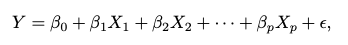

Or Equivalently: 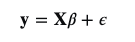


In [2]:
X = df.data.drop("petal width (cm)", axis=1)
y = df.data["petal width (cm)"]

We need to get our data in the format of the normalised equations, the solutions of which are the coefficents which minimize the ordinary least squares: 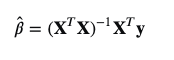

We need to add a column of 1s to replicate the b0 coefficient.

In [3]:
b0 = pd.Series(np.linspace(1,1,150))
X["b0"] = b0
X = X[["b0","sepal length (cm)","sepal width (cm)","petal length (cm)"]]

In [4]:
X.columns = ["b0","X1","X2","X3"]
X.head()

,b0,X1,X2,X3
0,1.0,5.1,3.5,1.4
1,1.0,4.9,3.0,1.4
2,1.0,4.7,3.2,1.3
3,1.0,4.6,3.1,1.5
4,1.0,5.0,3.6,1.4


Now we use this matrix to solve for the equations.

In [5]:
XT = X.values.transpose()
XTX = np.matmul(XT, X).values
XTX_inv = np.linalg.inv(XTX)
XTX_inv_XT = np.matmul(XTX_inv, XT)
b_hat = np.matmul(XTX_inv_XT, y)
b_hat =pd.Series(b_hat, index = ["b0","b1","b2","b3"])
b_hat

b0   -0.240307
b1   -0.207266
b2    0.222829
b3    0.524083
dtype: float64

These values seem reasonable. Let's see if they match up with the coefficients produced by the sklearn linear regression model.

In [6]:
from sklearn.linear_model import LinearRegression
X = df.data.drop("petal width (cm)", axis=1)
lm = LinearRegression(fit_intercept=True)
lm.fit(X,y)

LinearRegression()

In [7]:
lm.coef_

array([-0.20726607,  0.22282854,  0.52408311])

In [8]:
lm.intercept_

-0.24030738911225624

Now we will do a quick summary on testing whether linear regression is a good fit, not relevant to making our own model here, but always good practice! According to An Introduction to Statistical Learning (ISLP) we need to answer four key questions:
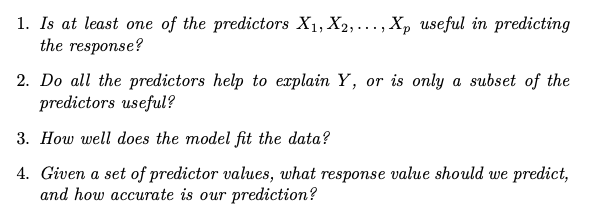

1. We want to test the null hypothesis that the coefficient estimations are not equal to 0: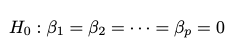
We do this by testing the F-statistic: 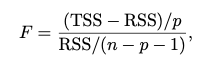 If there is no relationship and the coefficients are 0 then the F-statistic = 1 (both the numerator and demoninator = the variance of y). If the null hypothesis is false then the F-statistic > 1. To do this we need:

 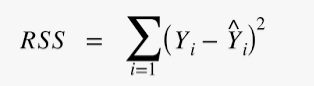

In [9]:
y_mean = y.mean()
y_mean = np.linspace(y_mean,y_mean,150)
X = df.data.drop("petal width (cm)", axis=1)
y_hat = lm.predict(X)
TSS = ((y - y_mean)**2).sum()
RSS = ((y - y_hat)**2).sum()
F = ((TSS - RSS)/3) / (RSS/(150 - 3 - 1))
F

734.3885371022118

If H0 is true then what is the probability that the F-statistic is this large (= p-value). F ~ F-distribution(p, n - p -1)

In [10]:
from scipy.stats import f

p = f.sf(F, 3, 146)
p

7.828193310549263e-88

SKLearn is not a good package for finding out the statistics and p-values of your regression, so instead we will use statsmodel as in ISLP. Note you need to add in the constant column, whereas you do not in sklearn.

In [39]:
import statsmodels.api as sm

b0 = pd.Series(np.linspace(1,1,150))
X = X[["sepal length (cm)","sepal width (cm)","petal length (cm)"]]
lm = sm.OLS(y, sm.add_constant(X))
result = lm.fit()
y_hat = result.predict(sm.add_constant(X))
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       petal width (cm)   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     734.4
Date:                Tue, 25 Jun 2024   Prob (F-statistic):           7.83e-88
Time:                        16:54:41   Log-Likelihood:                 36.751
No. Observations:                 150   AIC:                            -65.50
Df Residuals:                     146   BIC:                            -53.46
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.2403      0.178     -1.347      0.180      -0.593       0.112
sepal length (cm)    -0.2073      0.048     -4.363      0.000      -0.301      -0.113
sepal width (cm)      0.2228      0.049      4.553      0.000       0.126       0.320
petal length (cm)     0.5241      0.024     21.399      0.000       0.476       0.572
==============================================================================
Omnibus:                        5.609   Durbin-Watson:                   1.573
Prob(Omnibus):                  0.061   Jarque-Bera (JB):                6.811
Skew:                           0.223   Prob(JB):                       0.0332
Kurtosis:                       3.944   Cond. No.                         90.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So we have got the correct F-statistic and close enough p-value and can conclude our own calculations work as the package does. We can conclude that H0 is false.

Once we have set up the model we start to look at 2. whether all the predictors are necessary and add to our model. To do this we can look at whether the adjusted R-sqaured, the AIC and the BIC improve when we add and remove variables. For example look at the p-values the constant is much less significant than the others, let's see what happens when we remove it:

In [44]:
X = X[["sepal length (cm)","sepal width (cm)","petal length (cm)"]]
lm = sm.OLS(y, X)
result = lm.fit()
y_hat2 = result.predict(X)
result.summary().tables[0]

Dep. Variable:,petal width (cm),R-squared (uncentered):,0.982
Model:,OLS,Adj. R-squared (uncentered):,0.982
Method:,Least Squares,F-statistic:,2671.
Date:,"Tue, 25 Jun 2024",Prob (F-statistic):,5.99e-128
Time:,16:55:48,Log-Likelihood:,35.824
No. Observations:,150,AIC:,-65.65
Df Residuals:,147,BIC:,-56.62
Df Model:,3,,
Covariance Type:,nonrobust,,


As we can see the the AIC and BIC have improved. Note here statsmodel now gives us the uncentered R-squared, which is a slightly different formulae to the R-squared show above and we are not comparing like for like. AS we can see below the centered R-squared is a touch lower, as we would expect when removing parameters.


In [55]:
r_sq2 = 1 - sum((y - y_hat2) ** 2) / sum((y - y.mean()) ** 2)
r_sq2

0.937077631758193

3: Now we judge how well the model fits the data. We do this by looking at the RMSE as well as the R-sqaured.

In [56]:
from statsmodels.tools.eval_measures import rmse
rmse(y,y_hat) #With intercept coef

0.1893902086650325

In [57]:
rmse(y,y_hat2) #Without intercept coef

0.1905638165002068

We can see the RMSE has increased very slightly when we remove the intercept as a parameter.

In step 4. we look at the difference between model bias and the 'reducible error' we get by improving the estimation of our beta values and the irredicuble error that comes from our error term e, which represents natural variation and is an irreducible error.

When we make predictions about the mean predicted value we can create a confidence interval based on the uncertainty around our beta values (reducible error). When we make predictions about certain data points, we make a prediction interval based on the irreducible and reducible error.

The next aspect to look at is whether there is any interaction between our variables. So far we have assumed our variables to be independent of each other, and that an increase in one, will not mean an increase in another. In our case on the Iris dataset it is clearly not the case, as an increase in sepal length likely means an increase is sepal width and thus an even greater increase in petal width.

To look at this we create another interaction variable, sepal length x sepal width:

In [61]:
inter = X["sepal length (cm)"] * X["sepal width (cm)"]
X["int"] = inter
X = X[["int","sepal length (cm)","sepal width (cm)","petal length (cm)"]]
lm = sm.OLS(y, X)
result = lm.fit()
result.summary().tables[0]

Dep. Variable:,petal width (cm),R-squared (uncentered):,0.982
Model:,OLS,Adj. R-squared (uncentered):,0.982
Method:,Least Squares,F-statistic:,2021.
Date:,"Tue, 25 Jun 2024",Prob (F-statistic):,1.09e-126
Time:,17:10:11,Log-Likelihood:,36.981
No. Observations:,150,AIC:,-65.96
Df Residuals:,146,BIC:,-53.92
Df Model:,4,,
Covariance Type:,nonrobust,,


In [62]:
y_hat3 = result.predict(X)
rmse(y,y_hat3) #With interaction

0.1891002200559776

Here we see the AIC and RMSE improve however, the BIC has not and R-Squared is the same. We could do similar things like add non-linear terms in to see the impacts too e.g. sepal length squared.

ISLP states the most common problems with linear regression as:
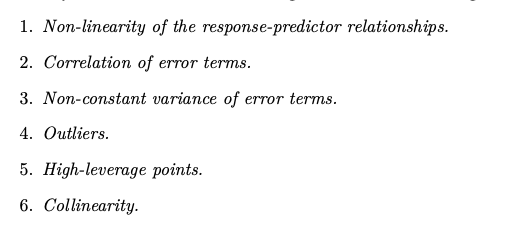

1. If the relationship is linear we should see the residuals being normally distributed around 0 with constant variance. To view this we plot residuvals against predicted values. (Let's use our most recent model).

Text(0.5, 0, 'fitted data')

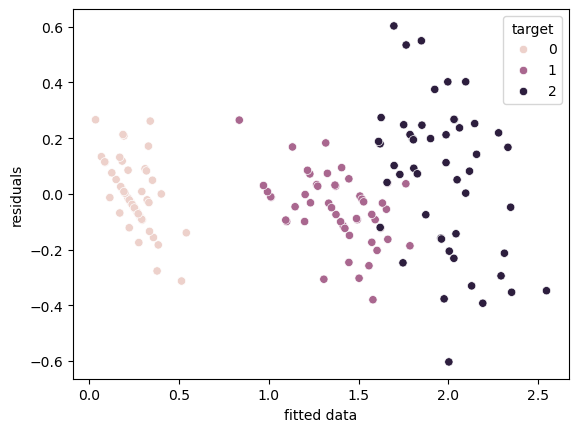

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=y_hat3, y=(y - y_hat3), hue=df.target)
plt.ylabel("residuals")
plt.xlabel("fitted data")

The variance is fairly constant and looks normally distributed. The variance is greater at higher fitted values however. We can look at a histogram of the residuals to see if they are normall distributed.

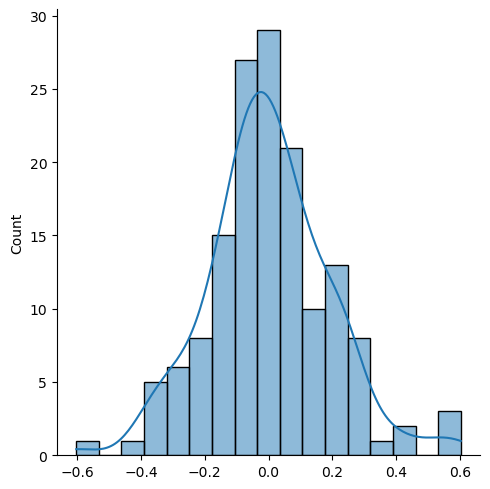

In [18]:
sns.displot((y - y_hat3), kde=True)

This appears fairly normal, which would imply linearity.

We do not see correlation of error terms against fitted values here, but we could check against the individual features though. This is usually an issue we time-series data though.

However, we do see some heteroscedasticity, where the variance is not constant, in this case the variance is greater for larger predicted values. In this case it is likely greater for one species of flower, which implies there is not a linear relationship across species (somewhat expected). To remedy this we can try to use a weighted least sqaures approach to deriving the parameters.

Dealing with outliers is fairly simple and they can often be left in the dataset, however dealing with high leverage points is less simple and often have a greater impact on the model. The leverage of each point should be calculated: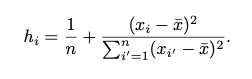

When dealing with collinearity we can calculate the correlation between our independent variables, or more precisely to deal with mulit-collinearity the VIF (variance inflation factor), which shows collinearity 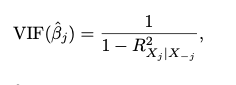

Collinearity can greatly increase the uncertainty in our beta estimations, which we can see in the t-statistics for the variables in question. To deal with collinearity we can simply remove one of the variables or combine them into a single variable.

Finally let's look at the impact of including the species as an independent variable. 

In [19]:
X = df.data
X["species"] = df.target
X[["cat1","cat2"]] = pd.get_dummies(X['species'], drop_first=True,dtype=int)
X.drop(["species","petal width (cm)"], inplace=True, axis=1)
inter = X["sepal length (cm)"] * X["sepal width (cm)"]
X["int"] = inter

In [20]:
lm = sm.OLS(y, X.values)
result = lm.fit()
result.summary().tables[0]

Dep. Variable:,petal width (cm),R-squared (uncentered):,0.987
Model:,OLS,Adj. R-squared (uncentered):,0.986
Method:,Least Squares,F-statistic:,1794.
Date:,"Tue, 25 Jun 2024",Prob (F-statistic):,1.25e-132
Time:,16:22:09,Log-Likelihood:,59.170
No. Observations:,150,AIC:,-106.3
Df Residuals:,144,BIC:,-88.28
Df Model:,6,,
Covariance Type:,nonrobust,,


In [21]:
y_hat4 = result.predict(X)
rmse(y,y_hat4) #With species

0.16309817790156134

The RMSE has improved considerably compared to the other changes, as well as the AIC and BIC. The adjusted R-Squared remains the same.

With that we can conclude our look into linear regression models, and move onto something a bit more interesting!